
  0%|          | 0/500 [00:00<?, ?it/s]
squared reconstruction average batch error: 435.86971953125:   0%|          | 1/500 [00:01<11:50,  1.42s/it]
squared reconstruction average batch error: 421.83988125:   0%|          | 2/500 [00:02<10:58,  1.32s/it]   
squared reconstruction average batch error: 412.35816484375:   1%|          | 3/500 [00:03<10:38,  1.29s/it]
squared reconstruction average batch error: 411.30018125:   1%|          | 4/500 [00:04<10:12,  1.23s/it]   
squared reconstruction average batch error: 410.336778125:   1%|          | 5/500 [00:05<09:53,  1.20s/it]
squared reconstruction average batch error: 406.7774546875:   1%|          | 6/500 [00:07<09:38,  1.17s/it]
squared reconstruction average batch error: 132.6077548828125:  60%|██████    | 301/500 [05:39<03:33,  1.07s/it]

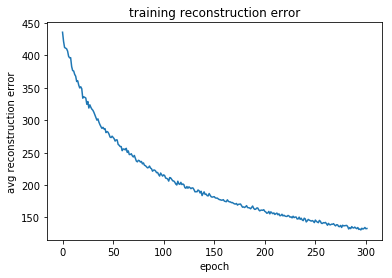

DEBUG: mapping instances over using TrRBM
DEBUG: preparing target instances
DEBUG: generating black-box rewards
done


In [191]:
import numpy as np
import tensorflow as tf
import trrbm
import utils
import pickle
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import gym

import sys
sys.path.append('../taylor_master/lib/env/')
from threedmountain_car import ThreeDMountainCarEnv

N_MAPPED = 5000
target_env = ThreeDMountainCarEnv()

def load_samples(path):
    with open(path, "rb") as f:
        return pickle.load(f)
    
def unpack_samples(samples, action_encoder, fit_encoder=True):
    unpacked = []
    actions = []
    for sample in samples:
        state = np.array(sample[0])
        state_prime = np.array(sample[2])
        reward = np.array(sample[3])
        terminal = np.array(int(sample[4]))
        
        # need to one-hot-encode the action 
        action = [int(sample[1])]
        
        if action_encoder is not None:
            unpacked.append(np.concatenate([state,state_prime]))
            actions.append(action)
        else:
            unpacked.append(np.concatenate([state,state_prime,action]))
            
    if action_encoder is not None:
        if fit_encoder == True:
            action_encoder.fit(np.array(actions).reshape(-1,1))
        actions = action_encoder.transform(np.array(actions).reshape(-1,1)).astype(float)
        unpacked = np.concatenate([unpacked,actions],axis=1)
    else:
        unpacked = np.stack(unpacked)
    return action_encoder, unpacked

def unpack_episodes(episodes, action_encoder, fit_encoder=False):
    samples = []
    for episode in episodes:
        for sample in episode:
            samples.append(sample)
    _, unpacked = unpack_samples(samples, action_encoder, fit_encoder=False)
    return unpacked
    
def even_out_samplesizes(samples1, samples2):
    if len(samples1) < len(samples2):
        samples1 = np.tile(samples1,[np.math.ceil(len(samples2)/(len(samples1))),1])
        np.random.shuffle(samples1)
        samples1 = samples1[:len(samples2)]
        
    if len(samples1) > len(samples2):
        samples2 = np.tile(samples2,[np.math.ceil(len(samples1)/(len(samples2))),1])
        np.random.shuffle(samples2)
        samples2 = samples2[:len(samples1)]
        
    return samples1, samples2


def prepare_target_triplets(target_mapped,state_size,action_size):

    target_states = target_mapped[:,:state_size]
    target_states_prime = target_mapped[:,state_size:-action_size]
    target_actions = target_mapped[:,-action_size:]
    actions_greedy = np.argmax(target_actions,axis=1)

    #actions_probabilities = (np.exp(-target_actions)/np.sum(np.exp(-target_actions),axis=1).reshape(-1,1))
    #actions_sampled = np.random.multinomial(1, actions_probabilities[0], N_ACT_SAMPLES).argmax(1)

    return target_states, target_states_prime, actions_greedy.reshape(-1,1)

def generate_rewards(env,states,actions):
    # for now just taking the actual environment as the black box function
    assert len(states) == len(actions)
    rewards = []
    for state, action in zip(states,actions):
        env.state = state
        next_state, reward, done, info = env.step(action[0])
        rewards.append(reward)
    return rewards
    
    
def main():
    
    source_random_path = '../taylor_master/data/2d_instances.pkl'
    target_random_path = '../taylor_master/data/3d_instances.pkl'
    source_optimal_path = '../taylor_master/data/optimal_instances.pkl'

    # load source task random samples
    source_action_encoder, source_random = unpack_samples(load_samples(source_random_path),OneHotEncoder(sparse=False))

    # load target task random samples
    target_action_encoder, target_random = unpack_samples(load_samples(target_random_path),OneHotEncoder(sparse=False))
    
    
    # prepare samples
    source_random, target_random = even_out_samplesizes(source_random, target_random)
    source_scaler, source_random = utils.standardize_samples(source_random)
    target_scaler, target_random = utils.standardize_samples(target_random)
    
    # load the TrRBM model

    rbm = trrbm.RBM(
        name = "TrRBM",
        v1_size = source_random.shape[1], 
        h_size = 100, 
        v2_size = target_random.shape[1], 
        n_data = source_random.shape[0], 
        batch_size = 100, 
        learning_rate = 0.00000001,
        num_epochs = 500, 
        n_factors = 40,
        k = 1,
        use_tqdm = True,
        show_err_plt = True
    )

    # train the TrRBM \model
    errs = rbm.train(source_random, target_random)
    
    if rbm.show_err_plt:
        plt.plot(range(len(rbm.cost)), rbm.cost)
        plt.title('training reconstruction error')
        plt.xlabel('epoch')
        plt.ylabel('avg reconstruction error')
        plt.show()

    # load source task optimal instances
    source_optimal = unpack_episodes(load_samples(source_optimal_path), source_action_encoder, fit_encoder=False)
    source_optimal = source_scaler.transform(source_optimal)

    # map to target instances
    print('DEBUG: mapping instances over using TrRBM')
    np.random.shuffle(source_optimal)
    target_mapped = rbm.v2_predict(source_optimal[:N_MAPPED])
    target_mapped = target_scaler.inverse_transform(target_mapped)
    
    # prepare target instances (i.e. decode action; split s from s')
    print('DEBUG: preparing target instances')
    action_size = int(target_action_encoder.feature_indices_[-1])
    state_size = int((target_mapped.shape[1]-target_action_encoder.feature_indices_[-1])/2)
    target_states, target_states_prime, target_actions = prepare_target_triplets(target_mapped,state_size,action_size)
    
    # get rewards from black-box model of reward function
    print('DEBUG: generating black-box rewards')
    rewards = generate_rewards(target_env,target_states,target_actions)
    
    # use transferred tuples to learn initial target policy \pi_{T}^{o}
    
        #### SEE builder notebook - fitted Q iteration
    
    # use initial target policy 
    
        #TODO load trained Q net, use with steps in env
    
    return rewards, rbm
    
if __name__ == '__main__':
    rewards, rbm =  main()
    print('done')

In [190]:
max(rewards)

-1.0

In [172]:
N_ACT_SAMPLES = 1


In [175]:
actions_greedy[:50]

array([0, 1, 0, 4, 4, 0, 4, 2, 2, 0, 4, 3, 2, 1, 0, 4, 1, 1, 0, 1, 4, 4, 3,
       3, 3, 3, 4, 0, 4, 4, 2, 1, 0, 1, 4, 0, 1, 2, 2, 1, 1, 3, 0, 0, 2, 3,
       4, 2, 1, 3])

In [132]:
source_optimal[0][-target_action_encoder.feature_indices_[-1]]

-0.10682081857624888

In [8]:
import taylor_master as master

SystemError: Parent module '' not loaded, cannot perform relative import

In [10]:
import sys

sys.path.append("../taylor_master/")

In [11]:
from lib.

In [13]:
standardize_samples(a)

NameError: name 'a' is not defined

In [32]:
ass = [[[1,2,3],[4,5,6]],[[1,2,3],[4,5,6]]]

In [33]:
[[s for s in a] for a in ass]

[[[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]]]

In [46]:
ass = load_samples(source_optimal_path)

5

In [56]:
source_random[0]

array([ 1.4063165 , -0.93932741,  1.33327236, -0.98875802,  1.39699458,
       -0.70753109, -0.69800429])

In [69]:
a=load_samples(source_random_path)

sr = []
for sample in a:
    sr.append(sample[1])

In [73]:
set(sr)

{0, 1, 2}

In [70]:
a=load_samples(source_random_path)

so = []
for sample in a:
    so.append(sample[1])

In [91]:
source_action_encoder.transform(np.array(sr).reshape(-1,1))

array([[ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.]])

In [119]:
target_mapped.shape

(5000, 13)